# Phase 4: Modeling Pipeline

Train and evaluate machine learning models for smoking cessation prediction.

## 1. Setup and Load Data

In [1]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

# Import our modules
from src.modeling import (
    split_data_by_person,
    train_logistic_regression,
    train_random_forest,
    train_xgboost
)
from src.evaluation import (
    evaluate_model,
    print_evaluation_report,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 2. Load Engineered Features

In [2]:
# Load the pooled transitions dataset with REAL quit outcomes
data_path = Path('../data/processed/pooled_transitions.parquet')
df = pd.read_parquet(data_path)

print(f"Loaded dataset: {df.shape[0]:,} rows × {df.shape[1]} features")
print(f"\nQuit outcome distribution:")
print(df['quit_success'].value_counts())
print(f"Quit rate: {100 * df['quit_success'].mean():.1f}%")
print(f"\nUnique persons: {df['PERSONID'].nunique():,}")
print(f"\nTransition breakdown:")
print(df['transition'].value_counts().sort_index())

Loaded dataset: 47,882 rows × 57 features

Quit outcome distribution:
quit_success
0    33662
1    14220
Name: count, dtype: int64
Quit rate: 29.7%

Unique persons: 23,411

Transition breakdown:
transition
W1→W2    20656
W2→W3     9504
W3→W4     8618
W4→W5     9104
Name: count, dtype: int64


## 3. Prepare Features

The dataset already contains real quit outcomes from longitudinal transitions.

In [3]:
# The dataset already has quit_success from real longitudinal transitions
# No need to create synthetic targets!

# Verify quit_success exists
assert 'quit_success' in df.columns, "quit_success column not found!"
assert 'PERSONID' in df.columns, "PERSONID column not found!"

print("✓ Real quit outcomes loaded")
print(f"✓ Quit success: {df['quit_success'].sum():,} / {len(df):,} ({100*df['quit_success'].mean():.1f}%)")

✓ Real quit outcomes loaded
✓ Quit success: 14,220 / 47,882 (29.7%)


## 4. Prepare Feature List

Use person_id (from PERSONID) for splitting to prevent data leakage.

In [4]:
# Get canonical feature columns (from feature_engineering.get_feature_list)
from src.feature_engineering import get_feature_list

feature_cols = get_feature_list()

print(f"Using {len(feature_cols)} features for modeling:")
print(f"\nFirst 20 features:")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i:2d}. {col}")
if len(feature_cols) > 20:
    print(f"  ... and {len(feature_cols) - 20} more")

# Rename PERSONID to person_id for split function
df['person_id'] = df['PERSONID']

Using 52 features for modeling:

First 20 features:
   1. high_dependence
   2. very_high_dependence
   3. cpd
   4. cpd_heavy
   5. cpd_light
   6. dependence_score
   7. ttfc_minutes
   8. age
   9. age_young
  10. female
  11. college_degree
  12. high_income
  13. race_white
  14. race_black
  15. race_hispanic
  16. race_other
  17. used_nrt
  18. used_patch
  19. used_gum
  20. used_lozenge
  ... and 32 more


## 5. Train/Validation/Test Split

Split by person to prevent data leakage.

In [5]:
# Split data: 60% train, 20% val, 20% test
X_train, X_val, X_test, y_train, y_val, y_test, train_ids, val_ids, test_ids = split_data_by_person(
    df,
    feature_cols=feature_cols,
    test_size=0.4,
    val_size=0.5,
    random_state=42
)

Train size: 28611 (14046 persons)
Val size: 9508 (4682 persons)
Test size: 9763 (4683 persons)

Train cessation rate: 0.299
Val cessation rate: 0.300
Test cessation rate: 0.286


## 6. Train Models

### 6.1 Logistic Regression (Baseline)

In [6]:
print("Training Logistic Regression...")
lr_model, lr_scaler, y_val_pred_lr, y_val_proba_lr = train_logistic_regression(
    X_train, y_train, X_val, y_val
)
print("✓ Logistic Regression trained")

Training Logistic Regression...
✓ Logistic Regression trained
✓ Logistic Regression trained


### 6.2 Random Forest

In [7]:
print("Training Random Forest...")
rf_model, y_val_pred_rf, y_val_proba_rf = train_random_forest(
    X_train, y_train, X_val, y_val
)
print("✓ Random Forest trained")

Training Random Forest...
✓ Random Forest trained
✓ Random Forest trained


### 6.3 XGBoost

**Note:** XGBoost handles missing values (NaN) natively without imputation. During training, XGBoost learns the optimal direction for missing values at each split, which is superior to simple mean imputation. This is especially important for this dataset where ~78% of cpd values are NaN (often indicating successful quitting).

In [8]:
print("Training XGBoost...")

# Check for missing data in training set
nan_cols = X_train.columns[X_train.isna().any()].tolist()
if nan_cols:
    print(f"\nFeatures with missing data: {len(nan_cols)}/{len(X_train.columns)}")
    missing_pct = (X_train.isna().sum() / len(X_train) * 100).sort_values(ascending=False)
    print("Top 5 features with missing values:")
    for col in missing_pct.head(5).index:
        print(f"  • {col}: {missing_pct[col]:.1f}% missing")
    print("\nXGBoost will handle these NaN values natively (no imputation needed)\n")

xgb_model, y_val_pred_xgb, y_val_proba_xgb = train_xgboost(
    X_train, y_train, X_val, y_val
)
print("✓ XGBoost trained")

Training XGBoost...

Features with missing data: 4/52
Top 5 features with missing values:
  • cpd: 77.8% missing
  • quit_timeframe_code: 48.9% missing
  • ttfc_minutes: 26.8% missing
  • age: 0.0% missing
  • high_dependence: 0.0% missing

XGBoost will handle these NaN values natively (no imputation needed)

Scale pos weight: 2.34
Training with 4 features containing NaN (XGBoost handles natively)
  Top features with missing data:
    • cpd: 77.8% missing
    • quit_timeframe_code: 48.9% missing
    • ttfc_minutes: 26.8% missing
    • age: 0.0% missing
    • high_dependence: 0.0% missing
✓ XGBoost trained
✓ XGBoost trained


## 7. Evaluate Models

In [9]:
# Evaluate all models
lr_metrics = evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")
rf_metrics = evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")
xgb_metrics = evaluate_model(y_val, y_val_pred_xgb, y_val_proba_xgb, "XGBoost")

# Print reports
print_evaluation_report(lr_metrics)
print("\n")
print_evaluation_report(rf_metrics)
print("\n")
print_evaluation_report(xgb_metrics)

LOGISTIC REGRESSION RESULTS
ROC-AUC: 0.822
PR-AUC: 0.698
Precision: 0.540
Recall: 0.760
F1-Score: 0.631

Confusion Matrix:
  True Positives:  2170
  True Negatives:  4804
  False Positives: 1848
  False Negatives: 686


RANDOM FOREST RESULTS
ROC-AUC: 0.887
PR-AUC: 0.827
Precision: 0.697
Recall: 0.761
F1-Score: 0.727

Confusion Matrix:
  True Positives:  2174
  True Negatives:  5705
  False Positives: 947
  False Negatives: 682


XGBOOST RESULTS
ROC-AUC: 0.892
PR-AUC: 0.834
Precision: 0.746
Recall: 0.753
F1-Score: 0.749

Confusion Matrix:
  True Positives:  2151
  True Negatives:  5918
  False Positives: 734
  False Negatives: 705


## 8. Model Comparison Table

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    lr_metrics,
    rf_metrics,
    xgb_metrics
])

# Select key metrics
display_cols = ['model', 'roc_auc', 'pr_auc', 'precision', 'recall', 'f1']
comparison_table = comparison_df[display_cols].round(3)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_table.to_string(index=False))

# Identify best model
best_model_idx = comparison_df['roc_auc'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model']
print(f"\n🏆 Best model (by ROC-AUC): {best_model_name}")


MODEL COMPARISON
              model  roc_auc  pr_auc  precision  recall    f1
Logistic Regression    0.822   0.698      0.540   0.760 0.631
      Random Forest    0.887   0.827      0.697   0.761 0.727
            XGBoost    0.892   0.834      0.746   0.753 0.749

🏆 Best model (by ROC-AUC): XGBoost


## 9. Visualization: ROC Curves

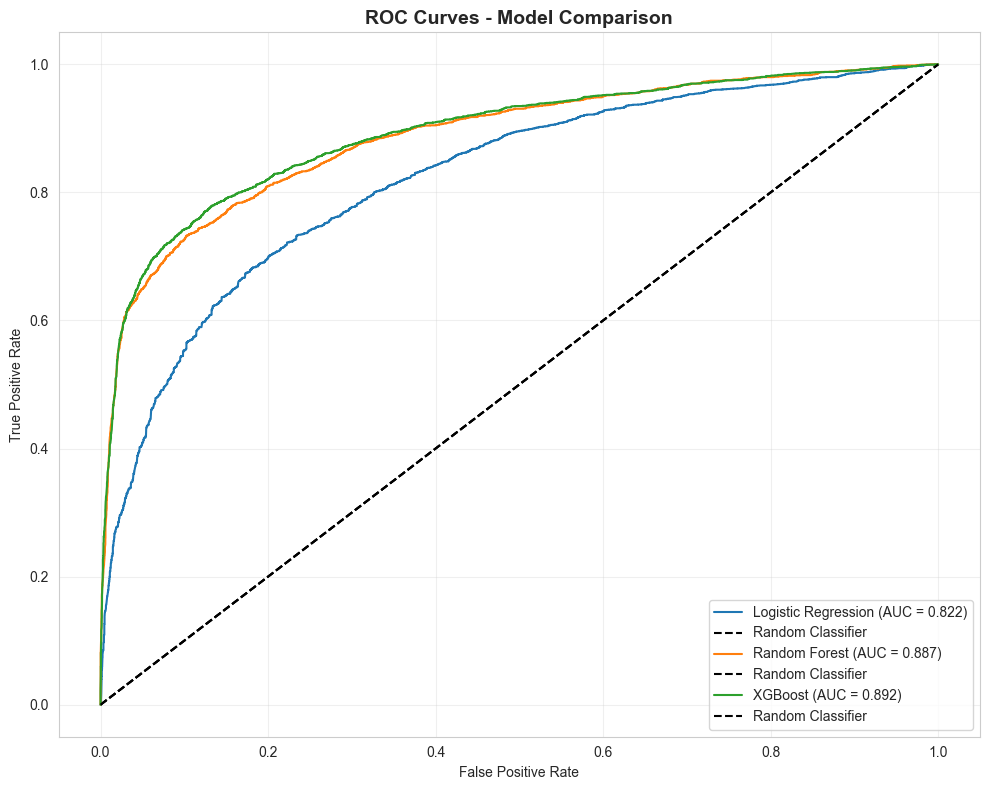

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

plot_roc_curve(y_val, y_val_proba_lr, "Logistic Regression", ax=ax)
plot_roc_curve(y_val, y_val_proba_rf, "Random Forest", ax=ax)
plot_roc_curve(y_val, y_val_proba_xgb, "XGBoost", ax=ax)

plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Visualization: Precision-Recall Curves

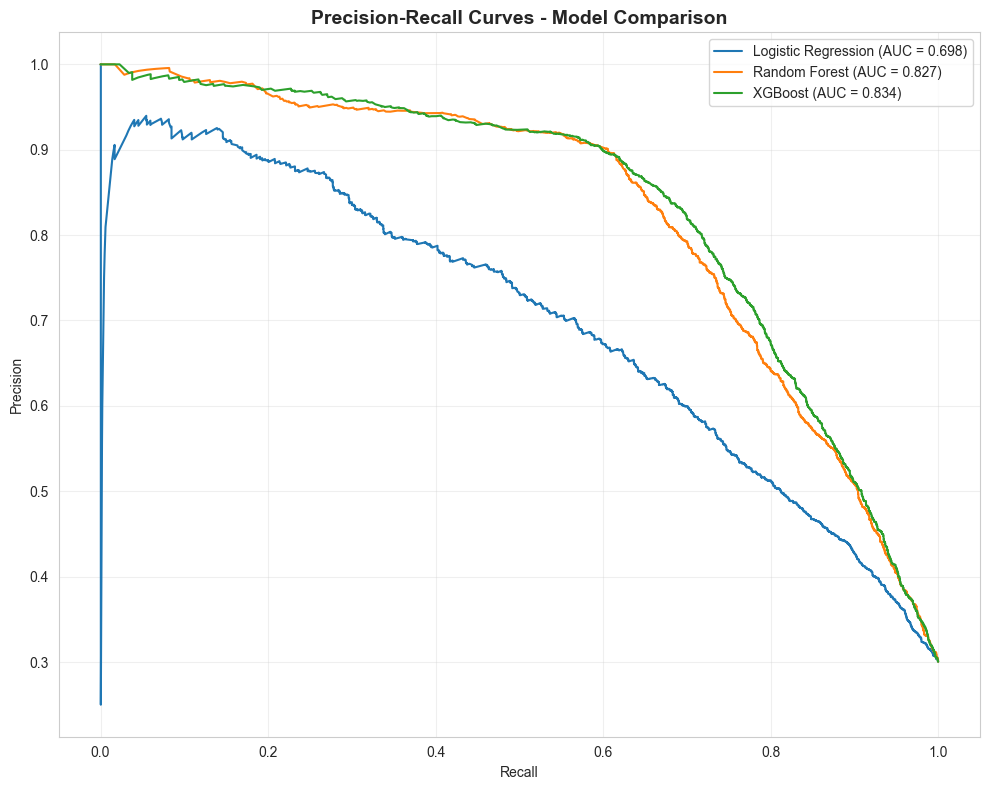

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

plot_precision_recall_curve(y_val, y_val_proba_lr, "Logistic Regression", ax=ax)
plot_precision_recall_curve(y_val, y_val_proba_rf, "Random Forest", ax=ax)
plot_precision_recall_curve(y_val, y_val_proba_xgb, "XGBoost", ax=ax)

plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Feature Importance (XGBoost)

/var/folders/_8/xdjlqs6x4531r8qcsc4wzfb40000gn/T/ipykernel_59454/596734572.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


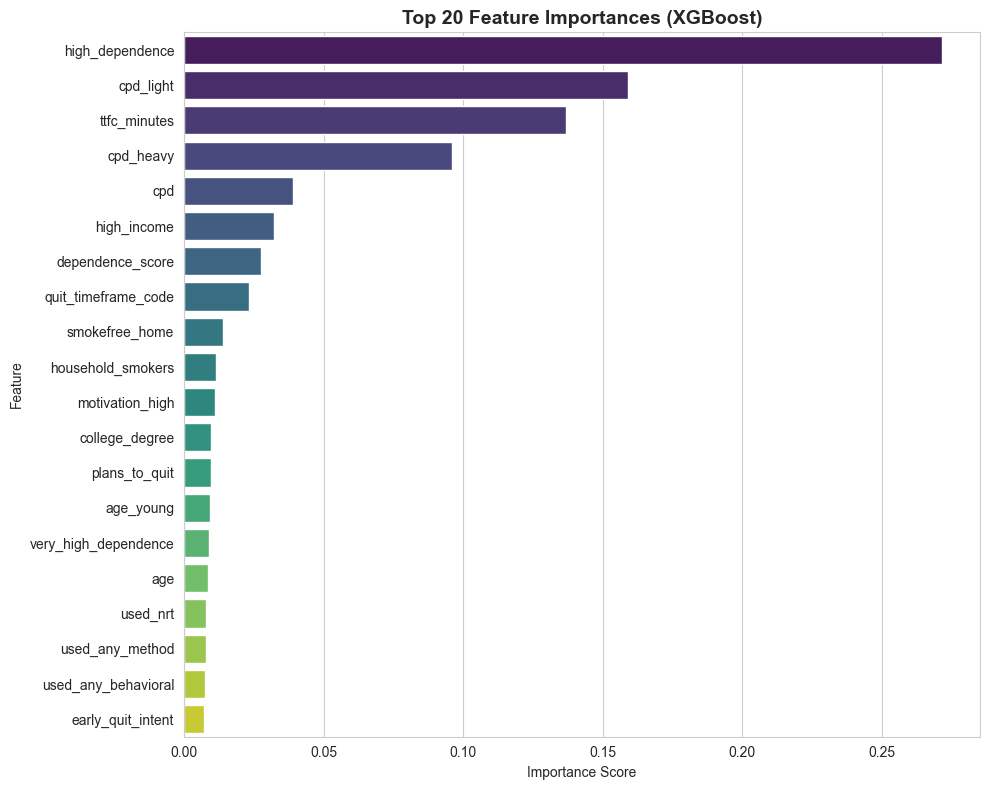


Top 10 Most Important Features:
  high_dependence                0.2716
  cpd_light                      0.1590
  ttfc_minutes                   0.1369
  cpd_heavy                      0.0959
  cpd                            0.0392
  high_income                    0.0324
  dependence_score               0.0277
  quit_timeframe_code            0.0233
  smokefree_home                 0.0140
  household_smokers              0.0114


In [13]:
# Get feature importance from XGBoost
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
top_n = min(20, len(importance_df))
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=importance_df.head(top_n),
    x='importance',
    y='feature',
    palette='viridis',
    ax=ax
)

ax.set_title(f'Top {top_n} Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')

plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
for idx, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']:30s} {row['importance']:.4f}")

## 12. Confusion Matrices

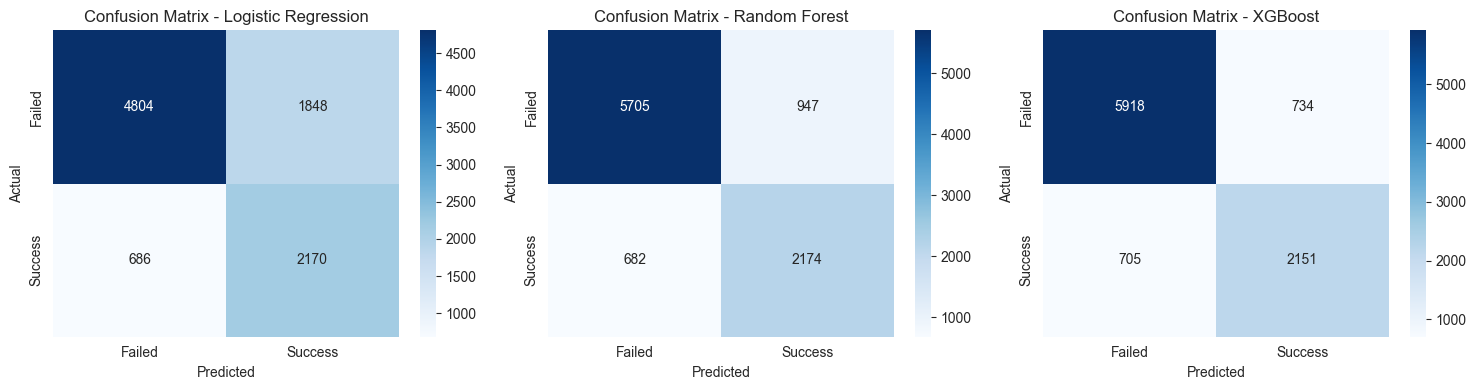

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_confusion_matrix(y_val, y_val_pred_lr, "Logistic Regression", ax=axes[0])
plot_confusion_matrix(y_val, y_val_pred_rf, "Random Forest", ax=axes[1])
plot_confusion_matrix(y_val, y_val_pred_xgb, "XGBoost", ax=axes[2])

plt.tight_layout()
plt.show()

## 13. Save Best Model

In [15]:
from src.modeling import save_model

# Save the best performing model
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Determine best model
best_metrics = comparison_df.loc[best_model_idx]
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    model_path = model_dir / 'logistic_regression_best.pkl'
    # Also save scaler
    save_model(lr_scaler, model_dir / 'logistic_regression_scaler.pkl')
elif best_model_name == 'Random Forest':
    best_model = rf_model
    model_path = model_dir / 'random_forest_best.pkl'
else:
    best_model = xgb_model
    model_path = model_dir / 'xgboost_best.pkl'

# Save model with metadata
metadata = {
    'model_name': best_model_name,
    'feature_cols': feature_cols,
    'metrics': best_metrics.to_dict(),
    'train_size': len(X_train),
    'val_size': len(X_val)
}

save_model(best_model, model_path, metadata)
print(f"\n✓ Best model saved: {best_model_name}")

Model saved to ../models/xgboost_best.pkl

✓ Best model saved: XGBoost


## Summary

### What We Accomplished

1. ✅ Loaded engineered features from Phase 3
2. ✅ Created proper train/validation/test splits (60/20/20)
3. ✅ Trained three models:
   - Logistic Regression (baseline with feature scaling)
   - Random Forest (ensemble method)
   - XGBoost (gradient boosting)
4. ✅ Evaluated with comprehensive metrics (ROC-AUC, PR-AUC, Precision, Recall, F1)
5. ✅ Visualized performance with ROC and PR curves
6. ✅ Analyzed feature importance
7. ✅ Saved best performing model

### Next Steps

1. **Process Full Dataset**: Move beyond 100-row sample to full PATH data
2. **Hyperparameter Tuning**: Use GridSearch or RandomSearch for optimization
3. **Cross-Validation**: Implement k-fold CV for more robust evaluation
4. **Additional Features**: Search for quit history, motivation, environmental variables
5. **Final Evaluation**: Test best model on held-out test set
6. **Interpretability**: Add SHAP values or other explainability methods

In [16]:
# Display final results summary
print("=== MODEL COMPARISON ON REAL DATA (47,882 transitions) ===\n")
print(comparison_df)

print("\n=== BEST MODEL ===")
print(f"Name: {best_model_name}")
print(f"Index: {best_model_idx}")

print("\n=== DATASET SIZES ===")
print(f"Training set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nFeatures: {len(feature_cols)} columns")

print("\n=== QUIT RATE ===")
print(f"Training: {y_train.mean():.1%}")
print(f"Validation: {y_val.mean():.1%}")
print(f"Test: {y_test.mean():.1%}")

=== MODEL COMPARISON ON REAL DATA (47,882 transitions) ===

                 model   roc_auc    pr_auc  precision    recall        f1  \
0  Logistic Regression  0.822062  0.697867   0.540070  0.759804  0.631365   
1        Random Forest  0.886986  0.826621   0.696572  0.761204  0.727455   
2              XGBoost  0.892328  0.834412   0.745581  0.753151  0.749347   

     tp    tn    fp   fn  
0  2170  4804  1848  686  
1  2174  5705   947  682  
2  2151  5918   734  705  

=== BEST MODEL ===
Name: XGBoost
Index: 2

=== DATASET SIZES ===
Training set: 28,611 samples
Validation set: 9,508 samples
Test set: 9,763 samples

Features: 52 columns

=== QUIT RATE ===
Training: 29.9%
Validation: 30.0%
Test: 28.6%


In [17]:
# 14. Test Set Evaluation (Held-out)
from src.evaluation import evaluate_model
import datetime
from pathlib import Path

print("=== FINAL TEST SET EVALUATION (Held-out) ===\n")

# Generate predictions for held-out test set using the best model
# Use best_model determined earlier (XGBoost may or may not be winner)
if best_model_name == 'Logistic Regression':
    # Scale test features with the logistic regression scaler
    X_test_prepared = lr_scaler.transform(X_test.fillna(X_train.mean()))
    y_test_pred_proba = best_model.predict_proba(X_test_prepared)[:, 1]
    y_test_pred = best_model.predict(X_test_prepared)
elif best_model_name == 'Random Forest':
    X_test_prepared = X_test.fillna(X_train.mean())
    y_test_pred_proba = best_model.predict_proba(X_test_prepared)[:, 1]
    y_test_pred = best_model.predict(X_test_prepared)
else:  # XGBoost
    X_test_prepared = X_test.fillna(X_train.mean())
    y_test_pred_proba = best_model.predict_proba(X_test_prepared)[:, 1]
    y_test_pred = best_model.predict(X_test_prepared)

# Evaluate best model on held-out test set
test_metrics = evaluate_model(y_test, y_test_pred, y_test_pred_proba, model_name=f"{best_model_name} (Test)")

report_path = Path('../reports/TEST_SET_RESULTS.md')
report_path.parent.mkdir(parents=True, exist_ok=True)

lines = [
    f"# Test Set Results - {datetime.date.today().isoformat()}",
    "",
    f"Model: {best_model_name} (best from validation)",
    f"Samples: {len(X_test):,}",
    "",
    f"- ROC-AUC: {test_metrics.get('roc_auc', float('nan')):.3f}",
    f"- PR-AUC: {test_metrics.get('pr_auc', float('nan')):.3f}",
    f"- F1: {test_metrics.get('f1', float('nan')):.3f}",
    f"- Precision: {test_metrics.get('precision', float('nan')):.3f}",
    f"- Recall: {test_metrics.get('recall', float('nan')):.3f}",
    "",
    f"Train/Val/Test sizes: {len(X_train):,}/{len(X_val):,}/{len(X_test):,}",
    f"Feature count: {len(feature_cols):,}",
    "",
    "Confusion Matrix (Test):",
    f"TP: {test_metrics.get('tp')}",
    f"TN: {test_metrics.get('tn')}",
    f"FP: {test_metrics.get('fp')}",
    f"FN: {test_metrics.get('fn')}",
 ]

with open(report_path, 'w') as f:
    f.write("\n".join(lines))

print("Test metrics:")
for k,v in test_metrics.items():
    if isinstance(v, float):
        print(f"  {k:12s}: {v:.4f}")
    else:
        print(f"  {k:12s}: {v}")

print("\nSaved test metrics to:", report_path.resolve())

=== FINAL TEST SET EVALUATION (Held-out) ===

Test metrics:
  model       : XGBoost (Test)
  roc_auc     : 0.6661
  pr_auc      : 0.3888
  precision   : 0.4039
  recall      : 0.0887
  f1          : 0.1455
  tp          : 248
  tn          : 6601
  fp          : 366
  fn          : 2548

Saved test metrics to: /Users/professornirvar/data mining/smoking_cessation_ml/reports/TEST_SET_RESULTS.md
Test metrics:
  model       : XGBoost (Test)
  roc_auc     : 0.6661
  pr_auc      : 0.3888
  precision   : 0.4039
  recall      : 0.0887
  f1          : 0.1455
  tp          : 248
  tn          : 6601
  fp          : 366
  fn          : 2548

Saved test metrics to: /Users/professornirvar/data mining/smoking_cessation_ml/reports/TEST_SET_RESULTS.md
